In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# On charge les données dans un dataframe "df"
# Avec 'event_id_cnty' comme index
df = pd.read_csv('terrorisme_sahel.csv', index_col='event_id_cnty')


############################################################
## FILTRES SUR LES COLONNES

# On récupère ici seulement les évènements qui nous intéressent
events_filter = ['Battles', 'Explosions/Remote violence', 'Violence against civilians', 'Strategic developments']
df = df[df['event_type'].isin(events_filter)]


############################################################
## TRANSFORMATION DES COLONNES

# On transforme la colonne "event_date" en datetime pour la manipuler plus facilement
df['event_date'] = pd.to_datetime(df['event_date'])
# On crée la colonne "month" en utilisant l'attribut month de datetime
df['month'] = df['event_date'].dt.month
# On ajoute la colonne juste après "year"
df.insert(3, 'month', df.pop('month'))


############################################################
## CREATION DE NOUVELLES COLONNES
# On crée une liste contenant les organisations terroristes
terrorist_groups = ['Ansaroul Islam',
                       'AQIM: Al Qaeda in the Islamic Maghreb',
                       'Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
                       'Islamic State (Sahel)',
                       'Islamic State (West Africa)',
                       'Islamic State (West Africa) - Lake Chad Faction',
                       'Islamic State (West Africa) - Lake Chad Faction and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
                       'Islamic State (West Africa) and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad',
                       'JNIM: Group for Support of Islam and Muslims',
                       'JNIM: Group for Support of Islam and Muslims and/or Islamic State (Sahel)',
                       'Katiba Gourma',
                       'Katiba Macina',
                       'Katiba Serma']

# On crée une fonction pour vérifier si un acteur est une organisation terroriste
def is_terrorist_actor(actor):
    return actor in terrorist_groups

# Puis on l'applique à chaque ligne du DataFrame et on crée une nouvelle colonne
# qui indique si pour un évènement l'un des acteurs est une organisation terrorist
df['is_terrorist_related'] = (df['actor1'].apply(is_terrorist_actor) |
                             df['assoc_actor_1'].apply(is_terrorist_actor) |
                             df['actor2'].apply(is_terrorist_actor) |
                             df['assoc_actor_2'].apply(is_terrorist_actor)).astype(int)

# On ajoute la colonne juste après "interaction"
df.insert(17, 'is_terrorist_related', df.pop('is_terrorist_related'))

# On crée une liste contenant les pmc russes
pmc_groups = ['Wagner Group']

# On crée une fonction pour vérifier si un acteur est une pmc russe
def is_pmc_actor(actor):
    return actor in pmc_groups

# Puis on l'applique à chaque ligne du DataFrame et on crée une nouvelle colonne
# qui indique si pour un évènement l'un des acteurs est une pmc russe
df['is_pmc_related'] = (df['actor1'].apply(is_pmc_actor) |
                             df['assoc_actor_1'].apply(is_pmc_actor) |
                             df['actor2'].apply(is_pmc_actor) |
                             df['assoc_actor_2'].apply(is_pmc_actor)).astype(int)

# On ajoute la colonne juste après "interaction"
df.insert(18, 'is_pmc_related', df.pop('is_pmc_related'))

# On ajoute une colonne qui permet d'associer chaque organisation terroriste
# à son organisation mère
#terrorist_org_filiation = {
#    'Ansaroul Islam': 'Al Qaida',
#    'AQIM: Al Qaeda in the Islamic Maghreb': 'Al Qaida',
#    'Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad': 'Etat Islamique',
#    'Islamic State (Sahel)' : 'Etat Islamique',
#   'Islamic State (West Africa)': 'Etat Islamique',
#    'Islamic State (West Africa) - Lake Chad Faction': 'Etat Islamique',
#    'Islamic State (West Africa) - Lake Chad Faction and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad': 'Etat Islamique',
#    'Islamic State (West Africa) and/or Boko Haram - Jamaatu Ahli is-Sunnah lid-Dawati wal-Jihad': 'Etat Islamique',
#    'JNIM: Group for Support of Islam and Muslims': 'Al Qaida',
#    'JNIM: Group for Support of Islam and Muslims and/or Islamic State (Sahel)': 'Al Qaida',
#    'Katiba Gourma': 'Al Qaida',
#    'Katiba Macina': 'Al Qaida',
 #   'Katiba Serma': 'Al Qaida'
#}

# On crée une fonction de mapping pour associer les valeurs du dictionnaire aux acteurs
#def map_filiation(row):
 #   for actor in ['actor1', 'assoc_actor_1', 'actor2', 'assoc_actor_2']:
#        if row[actor] in terrorist_org_filiation:
#            return terrorist_org_filiation[row[actor]]
#    return "Aucune"

# Puis on l'applique à chaque ligne du DataFrame, et on stocke les valeurs
# dans une novuelle colonne 'terrorist_org_filiation'
#df['terrorist_org_filiation'] = df.apply(map_filiation, axis=1)


############################################################
## NETTOYAGE DES COLONNES

# On remplace dans la colonne 'civilian_targeting' les valeurs par des booléens
df['civilian_targeting'] = df['civilian_targeting'].replace('Civilian targeting', 1)
df['civilian_targeting'] = df['civilian_targeting'].fillna(0)


############################################################
## SUPPRESSION DES COLONNES

# On supprime les colonnes qui nous serons d'aucune utilité
columns_to_drop = [
    'time_precision',
    'disorder_type',
    'sub_event_type',
    'actor1',
    'assoc_actor_1',
    'actor2',
    'assoc_actor_2',
    'interaction',
    'inter1',
    'inter2',
    'admin2',
    'admin3',
    'iso',
    'region',
    'location',
    'latitude',
    'longitude',
    'geo_precision',
    'source',
    'source_scale',
    'notes',
    'tags',
    'timestamp',
    'civilian_targeting'
]

#df = df.drop(columns=columns_to_drop, axis=1)


############################################################
## COPIE DU DATAFRAME

# On copie le dataframe nettoyé avant standardisation / normalisation dans 'df_viz'
# afin de conserver les colonnes qui pourront nous servir à créer facilement des graphiques
df_viz = df

############################################################
## STANDARDISATION / NORMALISATION DES VARIABLES

# On dichotomise la variable 'event_type' qui est de type catégorielle
# et qui sera très importante pour la suite de notre étude
#df = pd.get_dummies(df, columns=['event_type'], dtype=int)

# On dichotomise la variable 'country' qui nous permet de filtrer sur chaque pays cible
#df = pd.get_dummies(df, columns=['country'], dtype=int)

# On dichotomise la variable 'admin1' qui nous permet de filtrer sur chaque sous-région
#df = pd.get_dummies(df, columns=['admin1'], dtype=int)

# On dichotomise la variable 'terrorist_org_afiliation' qui nous permet de filtrer
# sur chaque afiliation d'un groupe terroriste
#df = pd.get_dummies(df, columns=['terrorist_org_filiation'], dtype=int)
##df = df.drop(columns=['terrorist_org_filiation_Aucune'], axis=1)


/var/folders/lp/lkkw3tl55g7204wxvgdc9sn80000gp/T/ipykernel_13855/890815230.py:111: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['civilian_targeting'] = df['civilian_targeting'].replace('Civilian targeting', 1)


In [143]:
df.head()

,event_date,year,time_precision,month,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp
event_id_cnty,,,,,,,,,,,,,,,,,,,,,
BFO11896,2024-04-30,2024,1,4,Political violence,Battles,Armed clash,JNIM: Group for Support of Islam and Muslims,NaN,2,...,Bawedara,10.0883,-3.9498,2,Al Zallaqa,New media,"On 30 April 2024, JNIM claimed to have ambushe...",4,NaN,1715049312
BFO11897,2024-04-30,2024,1,4,Political violence,Battles,Armed clash,JNIM: Group for Support of Islam and Muslims,NaN,2,...,Sarkounga,13.3170,-1.7903,1,Twitter; Undisclosed Source,Local partner-Other,"On 30 April 2024, JNIM militants attacked a po...",11,NaN,1715049312
BFO11898,2024-04-30,2024,1,4,Political violence,Battles,Armed clash,VDP: Volunteer for Defense of Homeland,NaN,4,...,Balave,12.3767,-4.1559,2,Undisclosed Source,Local partner-Other,"On 30 April 2024, volunteer fighters (VDP) car...",10,NaN,1715049312
MLI32402,2024-04-30,2024,1,4,Political violence,Violence against civilians,Attack,Unidentified Armed Group (Mali),NaN,3,...,Madina Kagoro,14.3779,-7.6690,2,Twitter,New media,"On 30 April 2024, unidentified armed men kille...",4,NaN,1715049545
NIR30820,2024-04-30,2024,1,4,Political violence,Violence against civilians,Attack,Unidentified Armed Group (Niger),NaN,3,...,Agadez,16.9700,7.9900,2,Studio Kalangou; Twitter,New media-National,"On 30 April 2024, an unidentified armed group ...",1,NaN,1715049548


In [144]:
# importation des librairies
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

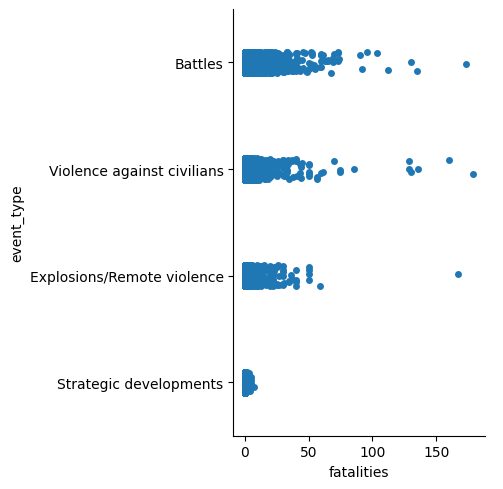

In [145]:
# Strip plot fatalities par event_type
sns.catplot( x ='fatalities',y = 'event_type', data = df)
plt.show()


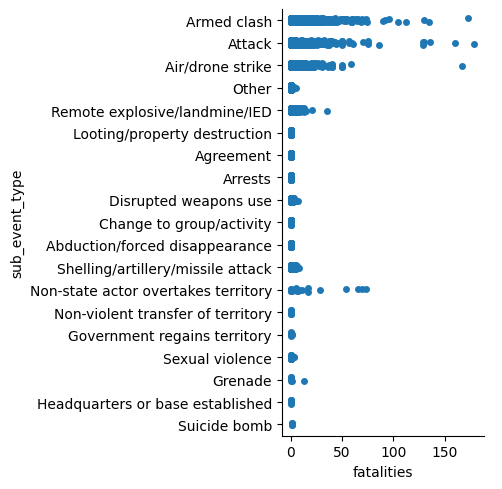

In [146]:
# Strip plot fatalities par sub_event_type
sns.catplot( x ='fatalities',y = 'sub_event_type', data = df)

plt.show()

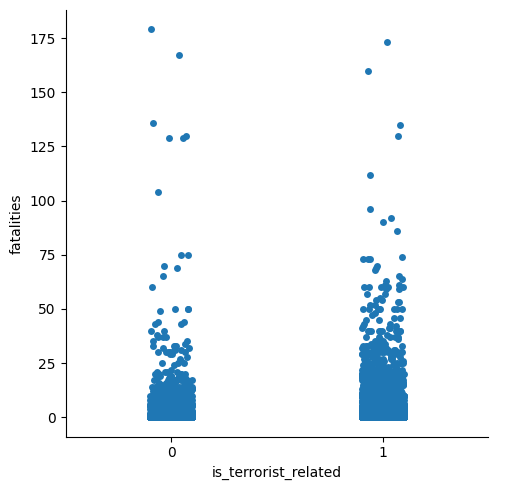

In [147]:
# Strip plot fatalities par is_terrorist_related
sns.catplot( y ='fatalities',x = 'is_terrorist_related', data = df)

plt.show()

In [148]:
# pour regarder le nombre d'événements terroristes par mois et par région
# on fait un grouper par mois sur la colonne event_date
grouper_mois = pd.Grouper(key ='event_date', freq ='m')

/var/folders/lp/lkkw3tl55g7204wxvgdc9sn80000gp/T/ipykernel_13855/3265769814.py:3: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouper_mois = pd.Grouper(key ='event_date', freq ='m')


In [149]:
# on fait la somme des événements terroristes par région et par mois
groupby_mois_region = df.groupby([grouper_mois, df['admin1']]).agg({'is_terrorist_related': 'sum'}).unstack()
groupby_mois_region.head()


is_terrorist_related                                           \
admin1                   Agadez Bamako Boucle du Mouhoun Cascades Centre   
event_date                                                                 
2021-06-30                  0.0    NaN               4.0      6.0    NaN   
2021-07-31                  NaN    0.0               7.0      1.0    NaN   
2021-08-31                  NaN    NaN               3.0      2.0    NaN   
2021-09-30                  NaN    0.0              13.0      7.0    0.0   
2021-10-31                  NaN    NaN              20.0     23.0    NaN   

                                                                 ...        \
admin1     Centre-Est Centre-Nord Centre-Ouest Centre-Sud Diffa  ...  Nord   
event_date                                                       ...         
2021-06-30        0.0        12.0          0.0        NaN   8.0  ...  16.0   
2021-07-31        NaN        21.0          NaN        0.0  12.0  ...  26.0   
2021-08-31        1.0        24.0          NaN        0.0  13.0  ...   2.0   
2021-09-30        0.0        16.0          NaN        NaN   6.0  ...   9.0   
2021-10-31        1.0        16.0          NaN        0.0   7.0  ...  24.0   

                                                                           \
admin1     Plateau-Central Sahel Segou Sikasso Sud-Ouest Tahoua Tillaberi   
event_date                                                                  
2021-06-30             NaN  28.0   1.0     2.0       NaN    0.0       4.0   
2021-07-31             NaN  18.0  21.0     4.0       0.0    0.0       7.0   
2021-08-31             NaN  32.0  12.0     3.0       0.0    NaN       2.0   
2021-09-30             NaN  32.0  12.0     4.0       NaN    NaN       1.0   
2021-10-31             NaN  39.0  13.0     3.0       1.0    0.0       7.0   

                              
admin1     Tombouctou Zinder  
event_date                    
2021-06-30        9.0    NaN  
2021-07-31        3.0    NaN  
2021-08-31        1.0    NaN  
2021-09-30        5.0    NaN  
2021-10-31        9.0    NaN  

[5 rows x 31 columns]

In [150]:
# on remplace les NaN par 0
groupby_mois_region= groupby_mois_region.fillna(0)

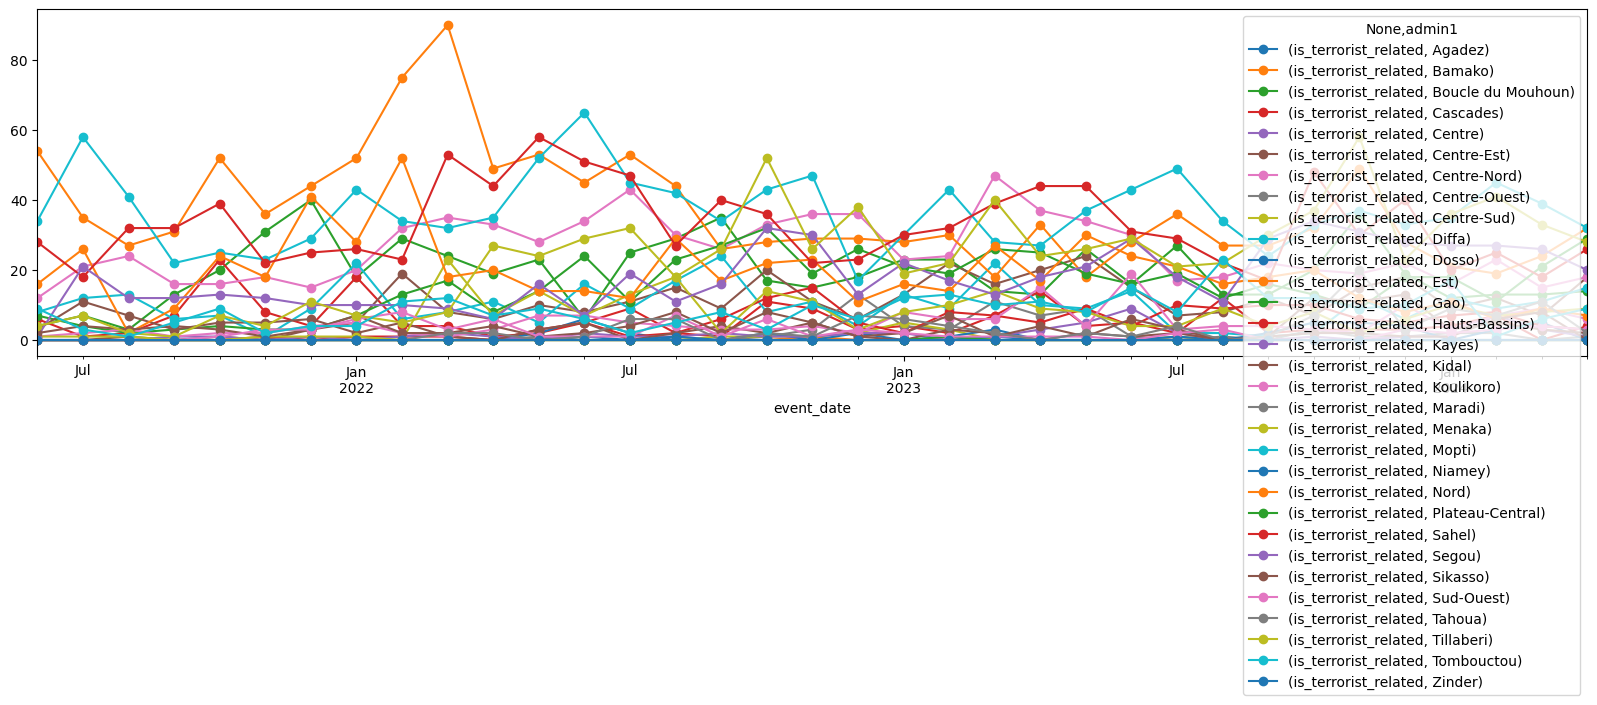

In [151]:
# tracé du nombre d'événements terroristes par région et par mois
groupby_mois_region.plot(figsize = (20,4.5), style ='o-');

In [152]:
# nombre d'événements terroristes par mois et par pays
groupby_mois_pays = df.groupby([grouper_mois, df['country']]).agg({'is_terrorist_related': 'sum'}).unstack()
groupby_mois_pays.head()

is_terrorist_related           
country            Burkina Faso Mali Niger
event_date                                
2021-06-30                  120   58    12
2021-07-31                  108  104    19
2021-08-31                   91   70    15
2021-09-30                  108   51     7
2021-10-31                  176   62    14

In [153]:
# on remplace les NaN par des 0
groupby_mois_pays= groupby_mois_pays.fillna(0)

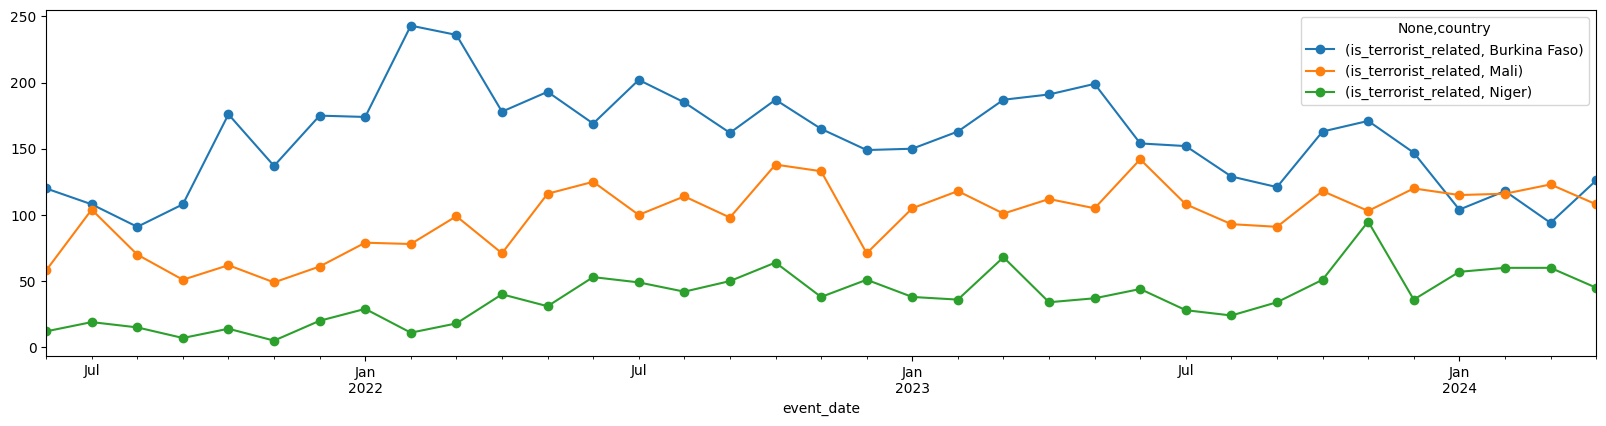

In [154]:
# on trace le nombre d'événements terroristes par mois et par pays
groupby_mois_pays.plot(figsize = (20,4.5), style ='o-');

# on peut voir une tendence à la baisse au Burkina Fasso et à la hausse au Mali et au Niger

In [155]:
# Validation croisée entre event_type et is_terrorist_related
cross_tab= pd.crosstab(df['event_type'], df['is_terrorist_related'])
cross_tab

is_terrorist_related,0,1
event_type,,
Battles,346,2884
Explosions/Remote violence,273,2082
Strategic developments,1251,2644
Violence against civilians,1887,2687


In [156]:
## Hypothèses : 
# 𝐻0 : La variable event_type est indépendante du type d'évènement terroriste ou non
# H1 : La variable event_type est dépendante du type d'évènement terroriste ou non


## Le test chi2 d'indépendance : 
from scipy.stats import chi2_contingency
resultats_chi2 = chi2_contingency(cross_tab)

statistique = resultats_chi2[0]
p_valeur = resultats_chi2[1]
print("La statistique du test est : ", statistique, "\n"
      "La p-valeur du test est : ", p_valeur, "\n")

# H0 rejeté et H1 acceptée: La variable event_type est dépendante du type d'évènement terroriste ou non

La statistique du test est :  1249.06184654158 
La p-valeur du test est :  1.6605255347645948e-270 



In [157]:
cross_tab2= pd.crosstab(df['sub_event_type'], df['is_terrorist_related'])
cross_tab2

is_terrorist_related,0,1
sub_event_type,,
Abduction/forced disappearance,363,967
Agreement,5,38
Air/drone strike,234,976
Armed clash,341,2860
Arrests,96,15
Attack,1514,1708
Change to group/activity,72,85
Disrupted weapons use,53,283
Government regains territory,3,5


In [158]:
## Hypothèses : 
# 𝐻0 : La variable sub_event_type est indépendante du type d'évènement terroriste ou non
# H1 : La variable sub_event_type est dépendante du type d'évènement terroriste ou non


## Le test chi2 d'indépendance : 
from scipy.stats import chi2_contingency
resultats_chi2 = chi2_contingency(cross_tab2)

statistique = resultats_chi2[0]
p_valeur = resultats_chi2[1]
print("La statistique du test est : ", statistique, "\n"
      "La p-valeur du test est : ", p_valeur, "\n")

# p-valeur à 0.0  H0 rejeté et H1 acceptée: La variable sub_event_type est dépendante du type d'évènement terroriste ou non

La statistique du test est :  1876.7775600220853 
La p-valeur du test est :  0.0 



In [159]:
# regarder les données par semaine par pays
# grouper par semaine
grouper_sem = pd.Grouper(key ='event_date', freq = 'w' )

/var/folders/lp/lkkw3tl55g7204wxvgdc9sn80000gp/T/ipykernel_13855/269145671.py:3: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  grouper_sem = pd.Grouper(key ='event_date', freq = 'w' )


In [160]:
# grouper par semaine et par pays
groupby_sem_pays = df.groupby([grouper_sem, df['country']]).agg({'is_terrorist_related': 'sum'}).unstack()
groupby_sem_pays.head()

is_terrorist_related           
country            Burkina Faso Mali Niger
event_date                                
2021-06-06                   19    7     5
2021-06-13                   34   17     2
2021-06-20                   35    8     0
2021-06-27                   21   17     2
2021-07-04                   22   27     5

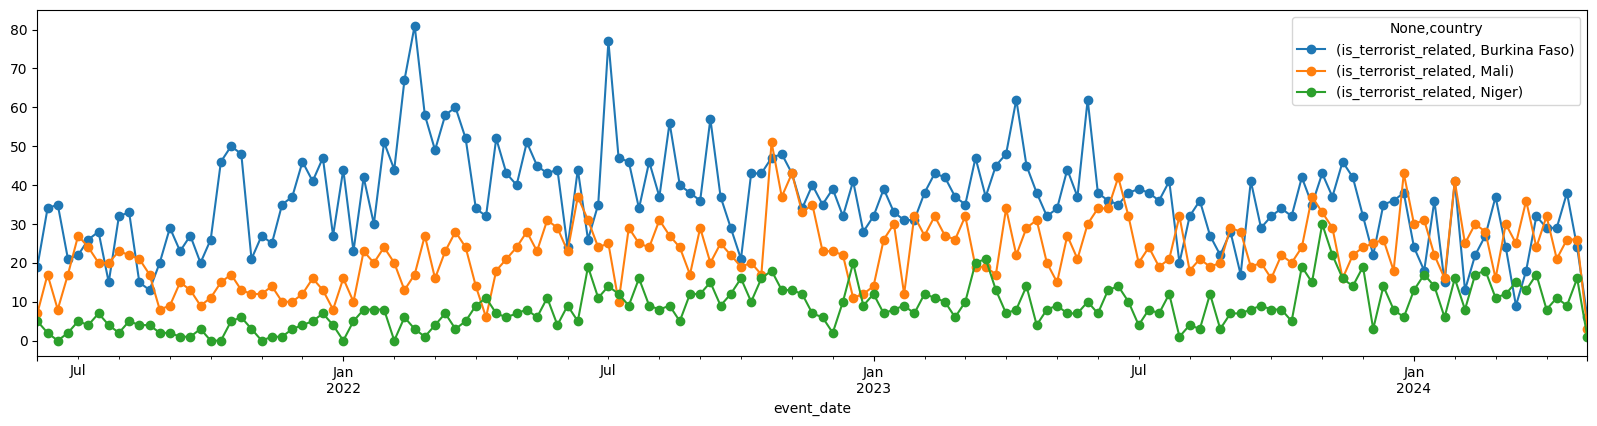

In [161]:
# tracer les courbes par semaines et par pays
groupby_sem_pays.plot(figsize = (20,4.5), style ='o-');

In [162]:
# refait la même chose par jour
grouper_jour = pd.Grouper(key ='event_date', freq = 'd' )
groupby_jour_pays = df.groupby([grouper_jour, df['country']]).agg({'is_terrorist_related': 'sum'}).unstack()
groupby_jour_pays.head()

is_terrorist_related           
country            Burkina Faso Mali Niger
event_date                                
2021-06-01                  2.0  2.0   NaN
2021-06-02                  3.0  0.0   0.0
2021-06-03                  3.0  2.0   0.0
2021-06-04                  3.0  1.0   1.0
2021-06-05                  7.0  1.0   1.0

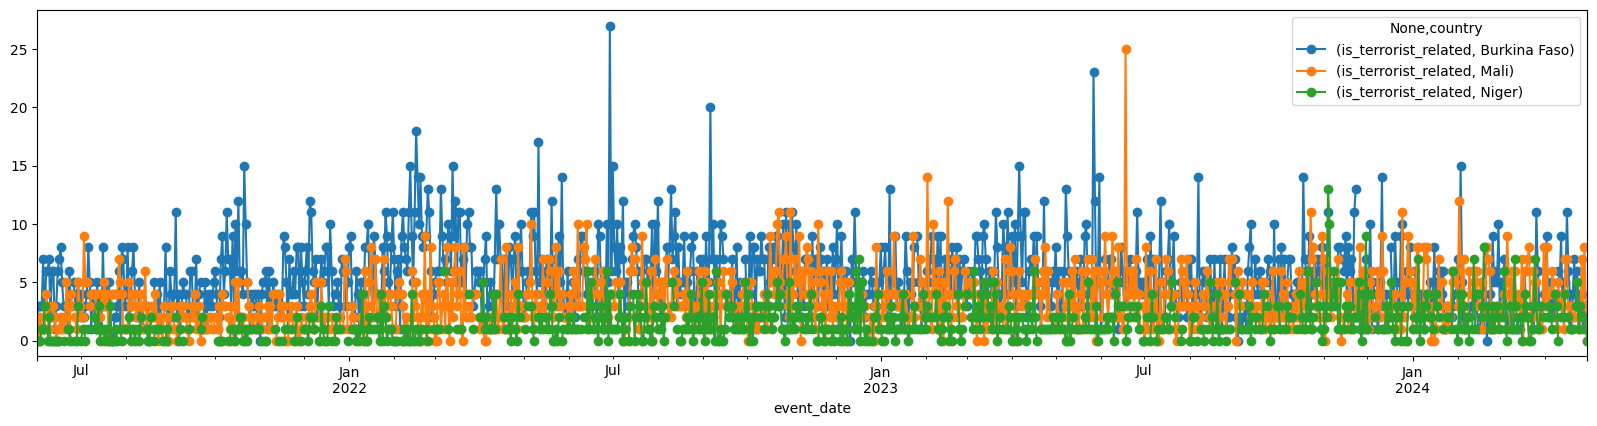

In [163]:
# tracer du nombre d'événements terroristes par jour et par pays
groupby_jour_pays.plot(figsize = (20,4.5), style ='o-');

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14054 entries, BFO11896 to MLI5182
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   event_date            14054 non-null  datetime64[ns]
 1   year                  14054 non-null  int64         
 2   time_precision        14054 non-null  int64         
 3   month                 14054 non-null  int32         
 4   disorder_type         14054 non-null  object        
 5   event_type            14054 non-null  object        
 6   sub_event_type        14054 non-null  object        
 7   actor1                14054 non-null  object        
 8   assoc_actor_1         1625 non-null   object        
 9   inter1                14054 non-null  int64         
 10  actor2                13362 non-null  object        
 11  assoc_actor_2         4301 non-null   object        
 12  inter2                14054 non-null  int64         
 13  interaction 

In [99]:
############################################################
## SUPPRESSION DES COLONNES

# On supprime les colonnes qui ne nous serons d'aucune utilité
columns_to_drop = [
    'time_precision',
    'admin2',
    'admin3',
    'iso',
    'region',
    'location',
    'latitude',
    'longitude',
    'geo_precision',
    'source',
    'source_scale',
    'notes',
    'tags',
    'timestamp',
    'civilian_targeting',
    'inter1',
    'inter2',
    'interaction',
    'event_date'

]

df = df.drop(columns=columns_to_drop, axis=1)



In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14054 entries, BFO11896 to MLI5182
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   year                  14054 non-null  int64 
 1   month                 14054 non-null  int32 
 2   disorder_type         14054 non-null  object
 3   event_type            14054 non-null  object
 4   sub_event_type        14054 non-null  object
 5   actor1                14054 non-null  object
 6   assoc_actor_1         1625 non-null   object
 7   actor2                13362 non-null  object
 8   assoc_actor_2         4301 non-null   object
 9   is_terrorist_related  14054 non-null  int64 
 10  is_pmc_related        14054 non-null  int64 
 11  country               14054 non-null  object
 12  admin1                14054 non-null  object
 13  fatalities            14054 non-null  int64 
dtypes: int32(1), int64(4), object(9)
memory usage: 1.6+ MB


In [101]:
# séparation des data et de la target
data = df.drop('is_terrorist_related', axis=1)
target= df['is_terrorist_related']

In [114]:
# On dichotomise les variables qui sont de type catégorielle ( si on le fait après le train test split: message d'erreur)
categorical_features = ['disorder_type','event_type','sub_event_type', 'actor1', 'assoc_actor_1', 'actor2', 'assoc_actor_2', 'country','admin1' ]
data_encoded = pd.get_dummies(data, columns=categorical_features, dtype=int)

In [115]:
data_encoded.head()

,year,month,is_pmc_related,fatalities,disorder_type_Political violence,disorder_type_Strategic developments,event_type_Battles,event_type_Explosions/Remote violence,event_type_Strategic developments,event_type_Violence against civilians,...,admin1_Nord,admin1_Plateau-Central,admin1_Sahel,admin1_Segou,admin1_Sikasso,admin1_Sud-Ouest,admin1_Tahoua,admin1_Tillaberi,admin1_Tombouctou,admin1_Zinder
event_id_cnty,,,,,,,,,,,,,,,,,,,,,
BFO11896,2024,4,0,4,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
BFO11897,2024,4,0,11,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BFO11898,2024,4,0,10,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MLI32402,2024,4,0,4,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
NIR30820,2024,4,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [116]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14054 entries, BFO11896 to MLI5182
Columns: 1158 entries, year to admin1_Zinder
dtypes: int32(1), int64(1157)
memory usage: 124.7+ MB


In [117]:
#1er découpage des données en respectant la chronologie. X_test1 y_test1 simuleront les données du futur
X_train1, X_test1, y_train1, y_test1 = train_test_split(data_encoded, target, test_size=0.2, random_state=123, shuffle = False)

In [118]:
#2eme découpage des données en respectant la chronologie. On va évaluer le modèle en faisant un nouveau découpage de X_train1, y_train1
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train1, y_train1, test_size=0.2, random_state=123, shuffle = False)

In [119]:
X_train2.head()

,year,month,is_pmc_related,fatalities,disorder_type_Political violence,disorder_type_Strategic developments,event_type_Battles,event_type_Explosions/Remote violence,event_type_Strategic developments,event_type_Violence against civilians,...,admin1_Nord,admin1_Plateau-Central,admin1_Sahel,admin1_Segou,admin1_Sikasso,admin1_Sud-Ouest,admin1_Tahoua,admin1_Tillaberi,admin1_Tombouctou,admin1_Zinder
event_id_cnty,,,,,,,,,,,,,,,,,,,,,
BFO11896,2024,4,0,4,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
BFO11897,2024,4,0,11,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BFO11898,2024,4,0,10,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MLI32402,2024,4,0,4,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
NIR30820,2024,4,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [122]:
# insatntiation de l'arbre de décision
dt_clf = DecisionTreeClassifier(criterion ='entropy', max_depth=4, random_state=123)
# entrainement sur X_train2 y_train2
dt_clf.fit(X_train2, y_train2)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)

In [124]:
y_pred2 = dt_clf.predict(X_test2)
pd.crosstab(y_test2, y_pred2, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,440,0
1,109,1700


In [140]:
print('Score entrainement 2:', dt_clf.score(X_train2, y_train2))
print('Score de test 2:', dt_clf.score(X_test2, y_test2))

Score entrainement 2: 0.9599733155436958
Score de test 2: 0.9515340151178302


In [125]:
feats = {}
for feature, importance in zip(X_train1.columns, dt_clf.feature_importances_):
    feats[feature] = importance 
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Importance'})

#Affichage des 8 variables les plus importantes
importances.sort_values(by='Importance', ascending=False).head(8)

,Importance
actor1_JNIM: Group for Support of Islam and Muslims,0.384340
actor2_JNIM: Group for Support of Islam and Muslims,0.305409
actor1_Islamic State (Sahel),0.209116
actor2_Islamic State (Sahel),0.101135
assoc_actor_2_Katiba Serma; JNIM: Group for Support of Islam and Muslims,0.000000
assoc_actor_2_Idourfane Ethnic Group (Mali),0.000000
assoc_actor_2_Islamic State (Sahel),0.000000
assoc_actor_2_Inates Communal Group (Niger),0.000000


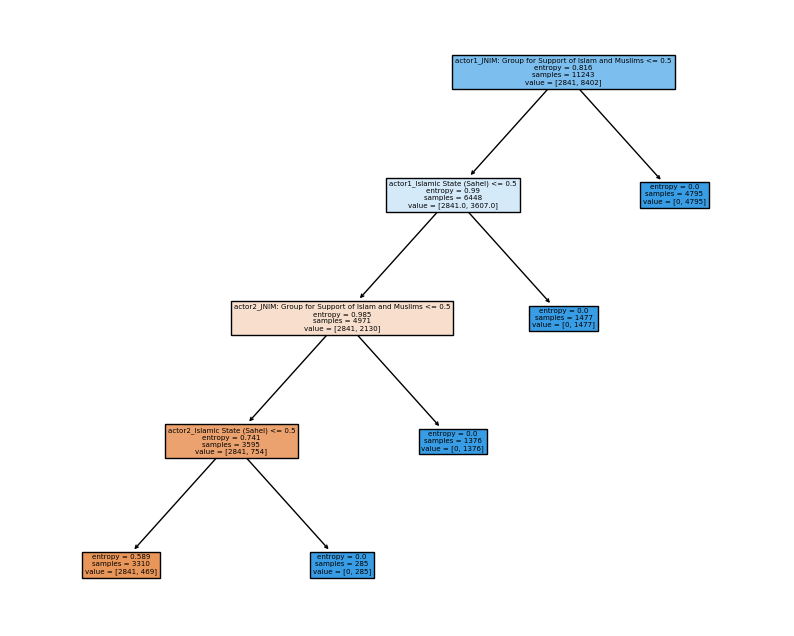

In [164]:
from sklearn import tree

plt.figure(figsize=(10,8))
tree.plot_tree(dt_clf, feature_names = X_train2.columns.tolist(), filled=True);

In [129]:
dt_clf.fit(X_train1, y_train1)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)

In [130]:
y_pred1 = dt_clf.predict(X_test1)

In [131]:
pd.crosstab(y_test1, y_pred1, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,916,0
1,609,1286


In [141]:
print('Score entrainement 1:', dt_clf.score(X_train1, y_train1))
print('Score de test 1:', dt_clf.score(X_test1, y_test1))

Score entrainement 1: 0.9582851552076848
Score de test 1: 0.7833511205976521


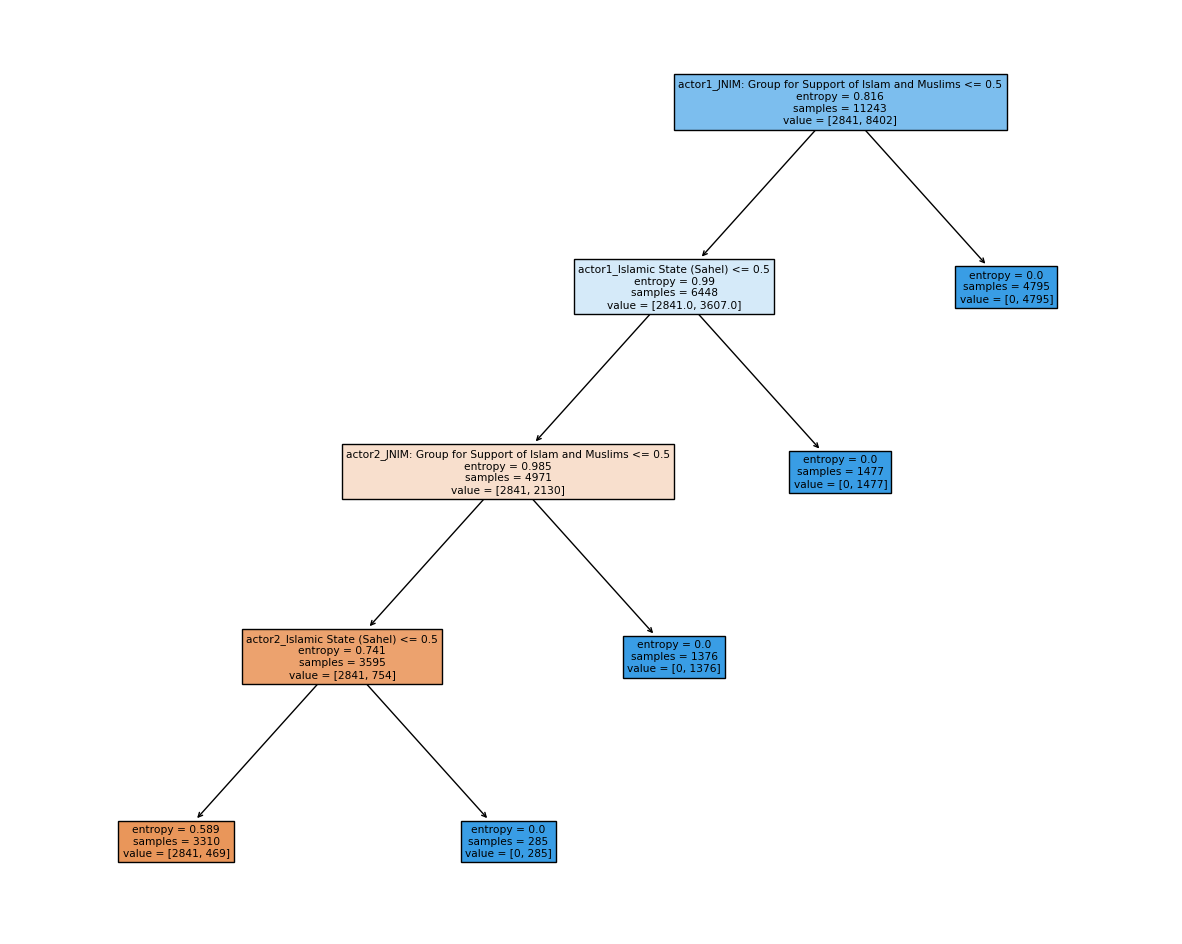

In [132]:
plt.figure(figsize=(15,12))
tree.plot_tree(dt_clf, feature_names = X_train1.columns.tolist(), filled=True);

In [134]:
dt_clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=321)
dt_clf_gini.fit(X_train2, y_train2)
y_pred2 = dt_clf_gini.predict(X_test2)
pd.crosstab(y_test2, y_pred2, rownames=['Classe réelle'], colnames=['Classe prédite'])


Classe prédite,0,1
Classe réelle,,
0,440,0
1,109,1700


In [136]:
dt_clf_gini.score(X_test2, y_test2)

0.9515340151178302